In [46]:
import os
import pickle
import numpy as np
import scipy.sparse as sp
from scipy.interpolate import griddata
from spektral.data import Dataset, Graph
from spektral.data.loaders import DisjointLoader, SingleLoader
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.regularizers import l2
from spektral.layers import MessagePassing, GCNConv, GATConv, ECCConv
from spektral.utils.sparse import sp_matrix_to_sp_tensor
from meshfunctions import *

In [30]:
def GetRandomFemSolution(n_min, n_max, elSize, n_order):
    points = GetRandomFixedPoints(n_min,n_max)
    g = GenerateGeometry(points)
    nodes, elements, boundaryNodes, internalNodes, alpha = MeshSurface(g,elSize)
    boundaryNodes = SortBoundaryNodes(boundaryNodes,nodes)
    A = np.concatenate([
        np.concatenate([[[1]],[[0]]],axis=1),
        np.concatenate([[[0]],[[1]]],axis=1)
        ],axis=0)
    r = 1
    BCfunc = GetRandomBCfuncAlpha(n_order,r=r)
    l_BC = BCfunc(alpha*2*np.pi)
    l = SolveFEM(nodes, elements, boundaryNodes, l_BC, internalNodes, r, A)
    return {'nodes': nodes, 'elements': elements, 'boundaryNodes': boundaryNodes, 'internalNodes': internalNodes, 'l': l, 'l_BC': l_BC, 'r': r}

def interpolate_boundary_to_interior(nodes, boundary_nodes, l_boundary):
    """
    Linearly interpolate given boundary values onto all interior nodes.

    Parameters
    ----------
    nodes : array_like, shape (N, 2)
        The (x, y) coordinates of all N nodes.
    boundary_nodes : array_like, shape (B,)
        The indices (into `nodes`) of the B boundary nodes.
    l_boundary : array_like, shape (B,)
        The scalar values of `l` at each boundary node.

    Returns
    -------
    l_full : ndarray, shape (N,)
        The interpolated values at *all* nodes: boundary ones match
        `l_boundary`, interior ones are filled by linear
        interpolation.
    """
    nodes = np.asarray(nodes)
    boundary_nodes = np.asarray(boundary_nodes, dtype=int)
    l_boundary = np.asarray(l_boundary)

    l_full = griddata(
        points = nodes[boundary_nodes],
        values = l_boundary,
        xi     = nodes,
        method = 'linear',
    )

    return l_full

def ConvertFemSolutionToGraph(solution):
    nodes = solution['nodes']
    elements = solution['elements']
    boundaryNodes = solution['boundaryNodes']
    internalNodes = solution['internalNodes']
    l = solution['l']
    l_interp = solution['l_interp']
    r = solution['r']

    N = nodes.shape[0] # Number of nodes
    boundary_mask = np.zeros((N, 1), dtype=np.float32)
    boundary_node_indices = np.array(boundaryNodes) # Ensure it's a numpy array
    boundary_mask[boundary_node_indices] = 1.0
    node_features = np.hstack((l_interp, boundary_mask)).astype(np.float32)
    node_labels = l.reshape(-1,r).astype(np.float32)

    # Construct Adjacency Matrix (a)
    #    Represents connections based on triangle elements.
    #    We create an undirected graph: if i and j share an edge, a[i,j] = a[j,i] = 1.

    edge_list = set()
    for i, j, k in elements:
        # Add edges for the triangle, ensuring undirectedness by adding both pairs
        edge_list.add(tuple(sorted((i, j))))
        edge_list.add(tuple(sorted((i, k))))
        edge_list.add(tuple(sorted((j, k))))

    # Convert set of tuples to row and column indices for sparse matrix
    row_indices = []
    col_indices = []
    for i, j in edge_list:
        row_indices.extend([i, j])
        col_indices.extend([j, i])

    # Create the sparse adjacency matrix
    adj_data = np.ones(len(row_indices), dtype=np.float32)
    adj_matrix_sparse = sp.csr_matrix((adj_data, (row_indices, col_indices)), shape=(N, N))

    # Construct Edge Features
    #    Features associated with each edge defined in the adjacency matrix.
    #    The order must correspond to the non-zero entries in the COO representation of 'a'.

    # Get edges in COO format to ensure order matches Spektral's expectation
    adj_matrix_coo = adj_matrix_sparse.tocoo()
    source_nodes = adj_matrix_coo.row
    target_nodes = adj_matrix_coo.col

    # Calculate edge features:
    # - Relative position (dx, dy)
    # - Edge length
    # - Difference in physical variable 'l'

    relative_pos = nodes[source_nodes] - nodes[target_nodes] # Shape: (num_edges, 2)
    edge_length = np.linalg.norm(relative_pos, axis=1, keepdims=True) # Shape: (num_edges, 1)
    physical_diff = l[source_nodes] - l[target_nodes] # Shape: (num_edges,)
    physical_diff = physical_diff.reshape(-1, 1) # Shape: (num_edges, n)

    # Concatenate edge features: [dx, dy, length, delta_l]
    edge_features = np.hstack((relative_pos, edge_length, physical_diff)).astype(np.float32)

    # Create the Spektral Graph object
    return Graph(x=node_features, 
                 a=adj_matrix_sparse, 
                 e=edge_features, 
                 y=node_labels, 
                 nodes = nodes, 
                 elements=elements, 
                 internalNodes=internalNodes, 
                 boundaryNodes = boundaryNodes)

# n_min = 4
# n_max = 10
# elSize = 0.2
# n_order = 3

# solution = GetRandomFemSolution(n_min, n_max, elSize, n_order)
# PlotFEMsolution(solution['nodes'], solution['elements'], solution['l'])
# solution['l_interp'] = interpolate_boundary_to_interior(solution['nodes'], solution['boundaryNodes'], solution['l_BC'])
# PlotFEMsolution(solution['nodes'], solution['elements'], solution['l_interp'])
# PlotMesh(solution['nodes'], solution['boundaryNodes'], solution['elements'])
# spektral_graph = ConvertFemSolutionToGraph(solution)

In [31]:
class FEMDataset(Dataset):
    def __init__(
        self,
        num_samples,
        cache_file="data/fem_graphs.pkl",
        n_min=4,
        n_max=10,
        elSize=0.2,
        n_order=3,
        **kwargs
    ):
        self.num_samples = num_samples
        self.cache_file = cache_file
        self.params = dict(n_min=n_min, n_max=n_max, elSize=elSize, n_order=n_order)
        super().__init__(**kwargs)

    def read(self):
        # 1) If we already generated & cached, just load that:
        if os.path.exists(self.cache_file):
            with open(self.cache_file, "rb") as f:
                graphs = pickle.load(f)
            return graphs

        # 2) Otherwise, generate from scratch:
        graphs = []
        for _ in range(self.num_samples):
            sol = GetRandomFemSolution(**self.params)
            sol['l_interp'] = interpolate_boundary_to_interior(sol['nodes'], sol['boundaryNodes'], sol['l_BC'])
            g = ConvertFemSolutionToGraph(sol)
            graphs.append(g)

        # 3) Cache for next time:
        with open(self.cache_file, "wb") as f:
            pickle.dump(graphs, f)

        return graphs

# — Usage — #

# Generate (and cache) graphs:
dataset = FEMDataset(num_samples=10)

# for g in dataset:
#     # 1) Dense features & labels
#     x_tf = tf.convert_to_tensor(g.x, dtype=tf.float32)
#     e_tf = tf.convert_to_tensor(g.e, dtype=tf.float32)
#     y_tf = tf.convert_to_tensor(g.y, dtype=tf.float32)

#     # 2) Sparse adjacency → tf.SparseTensor
#     A_csr = g.a.tocsr()             # ensure CSR
#     A_coo = A_csr.tocoo()           # easy access to .row/.col/.data
#     indices = np.vstack((A_coo.row, A_coo.col)).T
#     values  = A_coo.data
#     shape   = A_coo.shape

#     a_tf = tf.SparseTensor(indices=indices,
#                            values=values,
#                            dense_shape=shape) 
#     a_tf = tf.sparse.reorder(a_tf) 
#     break              


In [94]:
def GetK_tf(nodes_el, A, r):
    # Get the stiffness matrix for a triangular elements, function is vectorized so that a batch of elements can be processed at once
    #   nodes_el - [N,3,2] tensor which containes the x,y positions of the 3 nodes of N triangles
    #   A - [2*r,2*r] tensor which defines the linear PDE coefficients
    #   r - number of latent variables

    # calculate the triangle area and the B matrix which is a derivative of the shape functions (B = div(N))
    b = (tf.roll(nodes_el[:,:,1],1,axis=1) - tf.roll(nodes_el[:,:,1],2,axis=1))
    b = tf.reshape(b,(-1,3,1))
    c = (tf.roll(nodes_el[:,:,0],2,axis=1) - tf.roll(nodes_el[:,:,0],1,axis=1))
    c = tf.reshape(c,(-1,3,1))
    Area = tf.abs(tf.matmul(tf.reshape(nodes_el[:,:,0],(-1,1,3)),b))/2
    I = tf.reshape(tf.eye(r),(1,r,r))
    B = tf.concat([
        tf.concat([b[:,0:1]*I, b[:,1:2]*I, b[:,2:3]*I],-1),
        tf.concat([c[:,0:1]*I, c[:,1:2]*I, c[:,2:3]*I],-1)
    ],-2)/(2*Area)
    B_T = tf.transpose(B,(0,2,1))
    return tf.matmul(tf.matmul(B_T,A),B)*Area # calculates the stiffness matrix

def SolveFEM_tf(nodes, elements, boundaryNodes, l_BC, source_term, internalNodes, r, A_l):
    """
    Solve a 2D linear FEM problem using only TensorFlow operations.
    
    Args:
        nodes: TensorFlow tensor containing node coordinates
        elements: List of element node indices
        boundaryNodes: Indices of boundary nodes
        BCfunc: Function to compute boundary conditions
        alpha: Scalar parameter for boundary conditions
        internalNodes: Indices of internal nodes
        r: Number of degrees of freedom per node
        A_l: Linear operator coefficient (optional)
        A: Nonlinear operator function (optional)
    
    Returns:
        TensorFlow tensor with solution at all nodes
    """
    # Convert inputs to TensorFlow tensors if they aren't already
    if not isinstance(nodes, tf.Tensor):
        nodes = tf.convert_to_tensor(nodes, dtype=tf.float32)
    if not isinstance(elements, tf.Tensor):
        elements = tf.convert_to_tensor(elements, dtype=tf.int32)
    if not isinstance(boundaryNodes, tf.Tensor):
        boundaryNodes = tf.convert_to_tensor(boundaryNodes, dtype=tf.int32)
    if not isinstance(internalNodes, tf.Tensor):
        internalNodes = tf.convert_to_tensor(internalNodes, dtype=tf.int32)
    if not isinstance(l_BC, tf.Tensor):
        l_BC = tf.convert_to_tensor(l_BC, dtype=tf.float32)
    if not isinstance(source_term, tf.Tensor):
        source_term = tf.convert_to_tensor(source_term, dtype=tf.float32)
    
    # Initialize solution vector
    total_nodes = tf.shape(nodes)[0]
    l = tf.zeros((total_nodes, r), dtype=tf.float32)
    
    # Initialize global stiffness matrix
    total_dofs = total_nodes * r
    K = tf.zeros((total_dofs, total_dofs), dtype=tf.float32)
    
    # Assemble the global stiffness matrix
    for el in tf.unstack(elements):
        # Create element DOF indices
        el_indices = tf.reshape(
            tf.stack([r * k + tf.range(r, dtype=tf.int32) for k in tf.unstack(el)]), [-1]
        )
        
        # Gather element nodes
        nodes_el = tf.gather(nodes, el)
        # Create mesh grid of indices
        el_size = tf.shape(el_indices)[0]
        idx_range = tf.range(el_size, dtype=tf.int32)
        X_idx, Y_idx = tf.meshgrid(idx_range, idx_range)
        
        
        # Get element stiffness matrix
        nodes_el = tf.reshape(nodes_el, [1, 3, 2])
        K_el = GetK_tf(nodes_el, A_l, r)[0]
        
        # Update global stiffness matrix using scatter_nd_add
        indices = tf.stack([
            tf.gather(el_indices, tf.reshape(Y_idx, [-1])),
            tf.gather(el_indices, tf.reshape(X_idx, [-1]))
        ], axis=1)
        
        K_el_flat = tf.reshape(K_el, [-1])
        K = tf.tensor_scatter_nd_add(K, indices, K_el_flat)
    
    
    # Create boundary and internal DOF indices
    bc_indices = tf.reshape(
        tf.stack([r * i + tf.range(r, dtype=tf.int32) for i in tf.unstack(boundaryNodes)]), [-1]
    )
    internal_indices = tf.reshape(
        tf.stack([r * i + tf.range(r, dtype=tf.int32) for i in tf.unstack(internalNodes)]), [-1]
    )
    
    # Compute right-hand side vector
    l_BC_flat = tf.reshape(l_BC, [-1, 1])

    f = -tf.matmul(tf.gather(K, bc_indices, axis=1), l_BC_flat)
    f -= source_term

    
    # Extract the submatrix of K corresponding to internal DOFs
    K_BC = tf.gather(tf.gather(K, internal_indices), internal_indices, axis=1)
    f = tf.gather(f, internal_indices)
    
    # Solve the system using TensorFlow's matrix_solve
    l_internal = tf.linalg.solve(K_BC, f)
    
    # Reshape the solution
    n_CDOF = tf.shape(l_internal)[0] // r
    l_internal = tf.reshape(l_internal, (n_CDOF, r))
    
    # Update the solution vector
    # Using tensor_scatter_nd_update to assign values
    l = tf.tensor_scatter_nd_update(
        l, 
        tf.expand_dims(internalNodes, axis=1),
        l_internal
    )
    
    l = tf.tensor_scatter_nd_update(
        l, 
        tf.expand_dims(boundaryNodes, axis=1),
        tf.reshape(l_BC, (-1, r))
    )
    
    return l

def GetA(P_A,P_m):
    A = tf.matmul(P_A,P_A,transpose_a=True)
    A = tf.math.exp(P_m) * A / tf.sqrt(tf.reduce_mean(tf.square(A)))
    return A


class PatchedGCNConv(GCNConv):
    def call(self, inputs, mask=None):
        # inputs: a list [X, A] (or [X, A, E] depending on the layer)
        # mask:   can be None, a Tensor, or a list of Tensors
        if isinstance(mask, list) and mask and mask[0] is None:
            mask = None
        # Delegate to the real implementation
        # Note: super().call expects signature call(self, inputs, **kwargs)
        return super().call(inputs, mask=mask)
    

class PatchedGATConv(GATConv):
    def call(self, inputs, mask=None):
        if isinstance(mask, list) and mask and mask[0] is None:
            mask = None
        return super().call(inputs, mask=mask)

class PatchedECCConv(ECCConv):
    def call(self, inputs, mask=None):
        if isinstance(mask, list) and mask and mask[0] is None:
            mask = None
        return super().call(inputs, mask=mask) 

# --- main model -----------------------------------------------------------
class FEMGNN(tf.keras.Model):                # Sub-classing is the recommended way
    def __init__(self, hidden_dim, n_enc_layers, n_dec_layers, out_dim, r, ecc_conv_kernel_network = None, **kwargs):
        """
        hidden_dim : units in the encoder GCNs
        out_dim    : units in the final GCN output
        r          : scalar field dimensionality (2 in your example)
        """
        super().__init__(**kwargs)

        # ===== trainable FEM parameters ===================================
        P_A_initializer = tf.keras.initializers.RandomNormal(stddev=0.01)
        # P_A_initializer = tf.keras.initializers.Identity(gain=1.0)
        self.P_A = self.add_weight(
            name="P_A",
            shape=(2 * r, 2 * r),
            initializer=P_A_initializer,
            trainable=True,
        )
        self.P_m = self.add_weight(
            name="P_m",
            shape=(),                       # scalar
            initializer="zeros",
            trainable=True,
        )

        self.ecc_conv_kernel_network = ecc_conv_kernel_network

        # ===== graph encoder ==============================================
        self.in_dense = tf.keras.layers.Dense(hidden_dim, activation=None)
        self.n_enc_layers = n_enc_layers
        self.ecc_conv_kernel_network = ecc_conv_kernel_network
        self.enc_gcn_arr = [PatchedECCConv(hidden_dim, activation="relu", kernel_network=self.ecc_conv_kernel_network) for _ in range(self.n_enc_layers)]
        self.enc_mlp_arr = [Dense(hidden_dim, activation="relu") for _ in range(self.n_enc_layers)]

        # project encoded features to boundary values and source term
        self.to_lBC      = tf.keras.layers.Dense(r, activation=None)   # per-node Dirichlet BC
        self.to_src_term = tf.keras.layers.Dense(r, activation=None)   # per-node RHS/source

        # ===== graph decoder ==============================================
        self.latent_dense = tf.keras.layers.Dense(hidden_dim, activation=None)
        self.n_dec_layers = n_dec_layers
        self.dec_gcn_arr = [PatchedECCConv(hidden_dim, activation="relu", kernel_network=self.ecc_conv_kernel_network) for _ in  range(self.n_dec_layers)]
        self.dec_mlp_arr = [Dense(hidden_dim, activation="relu") for _ in range(self.n_enc_layers)]
        # self.out_gcn = PatchedGCNConv(out_dim,    activation=None)
        self.out_dense = tf.keras.layers.Dense(out_dim, activation=None)   # per-node RHS/source

    def call(self, inputs, training=False):
        """
        inputs = { 'x': node features  [N,F],
                   'a': SparseTensor   [N,N],
                   'mesh': dict(nodes, elements, boundaryNodes, internalNodes, r) }
        """
        x, a, e, mesh = inputs["x"], inputs["a"], inputs["e"], inputs["mesh"]

        # ---------- 1) encode --------------------------------------------
        h = self.in_dense(x)
        for i in range(self.n_enc_layers):
            h_gcn  = self.enc_gcn_arr[i]([h, a, e], training=training)
            h_mlp = self.enc_mlp_arr[i](h,training=training)
            h = h_gcn + h_mlp + h
            # h = h_mlp + h


        # ---------- 2) predict BC & RHS ----------------------------------
        l_BC       = self.to_lBC(tf.gather(h, mesh["boundaryNodes"]  , axis=0))                 # [N_boundary,r]
        source     = self.to_src_term(h)*0            # [N,r]

        # ---------- 3) assemble elliptic system coefficients --------------------------
        A_l = GetA(self.P_A, self.P_m)              # trainable & differentiable
        # print(A_l)

        # ---------- 4) FEM solve (autograd-friendly) ----------------------
        l_pred = SolveFEM_tf(mesh["nodes"],
                             mesh["elements"],
                             mesh["boundaryNodes"],
                             l_BC,
                             source,
                             mesh["internalNodes"],
                             mesh["r"],
                             A_l)                   # returns [N,r], differentiable

        # ---------- 5) concatenate and decode ----------------------------
        # h = tf.concat([h, l_pred], axis=-1)  # [N, hidden+r]
        # h = l_pred
        h = self.latent_dense(l_pred)
        for i in range(self.n_dec_layers):
            h_gcn = self.dec_gcn_arr[i]([h, a, e], training=training)
            h_mlp = self.dec_mlp_arr[i](h,training=training)
            h = h_gcn + h_mlp + h
            # h = h_mlp + h
        
        out = self.out_dense(h)

        return out, A_l                     # we expose l_pred for monitoring


In [ ]:
r = 1

loss_fn    = tf.keras.losses.MeanSquaredError()
optimizer  = tf.keras.optimizers.Adam(1e-3)
model      = FEMGNN(hidden_dim=64, n_enc_layers=0, n_dec_layers=0, out_dim=r, r=r, ecc_conv_kernel_network=[64,64])   # adjust r/out_dim as needed

# @tf.function                                     # XLA speeds things up
def train_on_graph(g):
    with tf.GradientTape() as tape:
        # --- convert NumPy/SciPy → TF ------------------------------------
        x  = tf.convert_to_tensor(g.x, dtype=tf.float32)
        e = tf.convert_to_tensor(g.e, dtype=tf.float32)
        y  = tf.convert_to_tensor(g.y, dtype=tf.float32)

        # A_coo   = g.a.tocoo()                                 # SciPy → COO
        # idx     = tf.stack([A_coo.row, A_coo.col], axis=1)
        # A_tf    = tf.SparseTensor(idx,
        #                           tf.cast(A_coo.data, tf.float32),
        #                           A_coo.shape)
        # A_tf    = tf.sparse.reorder(A_tf)
        A_csr = g.a.tocsr()             # ensure CSR
        A_coo = A_csr.tocoo()           # easy access to .row/.col/.data
        indices = np.vstack((A_coo.row, A_coo.col)).T
        values  = A_coo.data
        shape   = A_coo.shape

        a_tf = tf.SparseTensor(indices=indices,
                            values=values,
                            dense_shape=shape) 
        a_tf = tf.sparse.reorder(a_tf) 

        mesh    = dict(nodes         = tf.convert_to_tensor(g.nodes, tf.float32),
                       elements      = tf.convert_to_tensor(g.elements, tf.int32),
                       boundaryNodes = tf.convert_to_tensor(g.boundaryNodes, tf.int32),
                       internalNodes = tf.convert_to_tensor(g.internalNodes, tf.int32),
                       r             = tf.constant(r, dtype=tf.int32))

        preds, A_l = model({"x": x, "a": a_tf, "e": e, "mesh": mesh}, training=True)
        loss     = loss_fn(y, preds)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss, A_l

# --------- loop over epochs ----------------------------------------------
n_epochs = 100
loss_history = []
for epoch in range(1, n_epochs+1):
    epoch_loss = 0.0
    for g in dataset:                       # just iterate – no Loader needed
        loss, A_l = train_on_graph(g)
        epoch_loss += loss
    epoch_loss = epoch_loss/len(dataset)
    loss_history.append(epoch_loss)
    print(f"epoch {epoch:03d}  loss = {epoch_loss:.4g}")
    print(A_l)

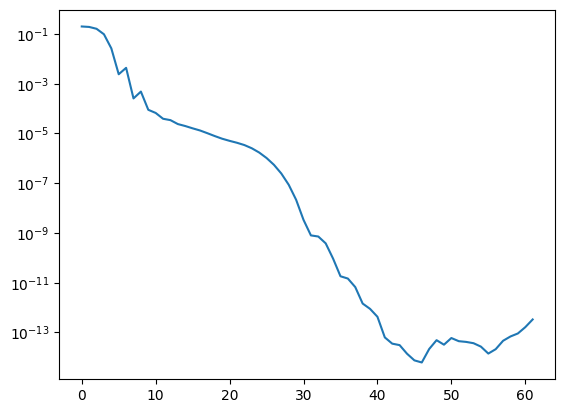

In [96]:
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.gca().set_yscale('log')